---
title: "FX Graph Mode Quantization in PyTorch"
author: "chris"
date: 2023-12-04
date-modified: 2023-12-04
draft: false
---

in this post I'll be using pytorch's FX graph mode quantization to quantize an R-CNN.  in the [previous post](https://cbhyphen.github.io/posts/pytorch-eager-qat/pytorch_eager_qat.html), I used eager mode quantization which resulted in model compression as well as latency gains compared to the same model on CPU.  there are significant differences between the two quantization methods and each has pros and cons.  so here I will touch on those differences as well as demonstrate how to quantize using FX graph mode.

at the time of writing this FX graph mode quantization is still a prototype feature.  this means that it's not as mature as eager mode which is a beta feature, although there does appear to be more effort on graphfx and it's even [encouraged over eager mode](https://pytorch.org/docs/stable/quantization.html#quantization-api-summary) for first time users.

one major difference is that FX graph requires the network to be [symbolically traceable](https://pytorch.org/tutorials/prototype/fx_graph_mode_quant_guide.html).  this requirement can result in [hacky modifications](https://ppwwyyxx.com/blog/2022/TorchScript-Tracing-vs-Scripting/#Recommendation) to code in the network that would otherwise be unnecessary and users have complained about this [complained about this](https://github.com/pytorch/pytorch/issues/48108).

according to documentation, the biggest advantages of FX graph mode quantization are:

- module fusion occurs automatically, something that could otherwise be tedious or error prone depending upon the complexity and size of your network
- functionals and torch ops also get converted automagically.  in this case that means no need to modify the bottleneck block to use float functional as done in the last post
- no requirement to insert quant/dequant stubs in the network which means you can avoid creating those additional wrapper classes

with that out of the way, let's dive into FX graph and QAT.  as before, we'll start with creating the resnet backbone but without having to modify the bottleneck to use float functional operator.

In [43]:
import torch
from torchvision.models.resnet import ResNet, Bottleneck, ResNet101_Weights


def resnet_101():
    resnet = ResNet(block=Bottleneck, layers=[3, 4, 23, 3])
    resnet.load_state_dict(ResNet101_Weights.DEFAULT.get_state_dict(progress=True))
    return resnet


resnet = resnet_101()

at this point, the resnet is fully traceable.  [tracing it with an example input](https://pytorch.org/docs/stable/generated/torch.jit.trace.html) will return a `ScriptModule` which can be used to get a [representation of graph's forward method](https://pytorch.org/docs/stable/generated/torch.jit.ScriptModule.html#torch.jit.ScriptModule.code).

In [ ]:
traced_module = torch.jit.trace(resnet, torch.rand(1, 3, 200, 200))
print(traced_module.code)

def forward(self,
    x: Tensor) -> Tensor:
  fc = self.fc
  avgpool = self.avgpool
  layer4 = self.layer4
  layer3 = self.layer3
  layer2 = self.layer2
  layer1 = self.layer1
  maxpool = self.maxpool
  relu = self.relu
  bn1 = self.bn1
  conv1 = self.conv1
  _0 = (relu).forward((bn1).forward((conv1).forward(x, ), ), )
  _1 = (layer1).forward((maxpool).forward(_0, ), )
  _2 = (layer3).forward((layer2).forward(_1, ), )
  _3 = (avgpool).forward((layer4).forward(_2, ), )
  input = torch.flatten(_3, 1)
  return (fc).forward(input, )



same as the eager mode preparation, the next step is to use torchvision's helper method `IntermediateLayerGetter` to extract layer outputs from the resnet to feed to the FPN.

In [44]:
from torchvision.models._utils import IntermediateLayerGetter


returned_layers = [1, 2, 3, 4]
return_layers = {f"layer{k}": str(v) for v, k in enumerate(returned_layers)}
resnet_layers = IntermediateLayerGetter(resnet, return_layers=return_layers)

the result of the layer getter is a module dict which returns an ordered dict from its forward method.  if we attempt to trace using strict mode, JIT will complain because of the mutable output type

```
AttributeError
...
AttributeError: expected a dictionary of (method_name, input) pairs
```

this can be ignored if we ["are sure that the container you are using in your problem is a constant structure and does not get used as control flow (if, for) conditions."](https://pytorch.org/docs/master/generated/torch.jit.trace.html)  since we know that the output won't change we can safely ignore this and set `strict=False`.  note that this isn't necessary for QAT preparation but it's helpful to know apriori if the parts of the model that we intend to quantize are indeed traceable.

In [ ]:
traced_module = torch.jit.trace(resnet_layers, torch.rand(1, 3, 200, 200), strict=False)
print(traced_module.code)

def forward(self,
    x: Tensor) -> Dict[str, Tensor]:
  layer4 = self.layer4
  layer3 = self.layer3
  layer2 = self.layer2
  layer1 = self.layer1
  maxpool = self.maxpool
  relu = self.relu
  bn1 = self.bn1
  conv1 = self.conv1
  _0 = (relu).forward((bn1).forward((conv1).forward(x, ), ), )
  _1 = (layer1).forward((maxpool).forward(_0, ), )
  _2 = (layer2).forward(_1, )
  _3 = (layer3).forward(_2, )
  _4 = {"0": _1, "1": _2, "2": _3, "3": (layer4).forward(_3, )}
  return _4



as before, create the backbone with FPN, however this time without any modifications.  after this, the module can be traced.  because the output is a mutable type (ordered dict) but it's structure will not change, strict mode needs to be set to false.  note that if you don't, there is a slightly different error (shown below) but the reason is the same.

```
RuntimeError: Encountering a dict at the output of the tracer might cause the trace to be incorrect, this is only valid if the container structure does not change based on the module's inputs. Consider using a constant container instead (e.g. for `list`, use a `tuple` instead. for `dict`, use a `NamedTuple` instead). If you absolutely need this and know the side effects, pass strict=False to trace() to allow this behavior.
```

In [45]:
from torchvision.models.detection.backbone_utils import BackboneWithFPN


in_channels_stage2 = resnet.inplanes // 8
in_channels_list = [in_channels_stage2 * 2 ** (i - 1) for i in returned_layers]
out_channels = 256
returned_layers = [1, 2, 3, 4]
return_layers = {f"layer{k}": str(v) for v, k in enumerate(returned_layers)}

bb_fpn = BackboneWithFPN(
    backbone=resnet,
    return_layers=return_layers,
    in_channels_list=in_channels_list,
    out_channels=out_channels
)

In [ ]:
traced_module = torch.jit.trace(bb_fpn, torch.rand(1, 3, 200, 200), strict=False)
print(traced_module.code)

def forward(self,
    x: Tensor) -> Dict[str, Tensor]:
  fpn = self.fpn
  body = self.body
  _0, _1, _2, _3, = (body).forward(x, )
  _4, _5, _6, _7, _8, = (fpn).forward(_0, _1, _2, _3, )
  _9 = {"0": _4, "1": _5, "2": _6, "3": _7, "pool": _8}
  return _9



now that we've verified the backbone with FPN is indeed traceable, we can create the R-CNN and prepare the model for QAT.  during preparation, FX graph mode will automatically insert observers and fuse modules.  the returned model is also now graph module.

```
GraphModule(
  (activation_post_process_0): HistogramObserver(min_val=inf, max_val=-inf)
  (body): Module(
    (conv1): ConvBnReLU2d(
      3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (weight_fake_quant): PerChannelMinMaxObserver(min_val=tensor([]), max_val=tensor([]))
    )
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Module(
      (0): Module(
        (conv1): ConvBnReLU2d(
          64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False
          (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (weight_fake_quant): PerChannelMinMaxObserver(min_val=tensor([]), max_val=tensor([]))
        )
        (conv2): ConvBnReLU2d(
          64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False
          (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (weight_fake_quant): PerChannelMinMaxObserver(min_val=tensor([]), max_val=tensor([]))
          ...
```

note that preparation now [requires an example input to determine the output types](https://pytorch.org/docs/stable/generated/torch.ao.quantization.quantize_fx.prepare_qat_fx.html).  as before, I'll freeze the first layer as well as batch norm stats

In [46]:
%%capture
import re
from torchvision.models.detection.faster_rcnn import FasterRCNN
from torch.ao.quantization import quantize_fx
from torch.ao.quantization.qconfig_mapping import get_default_qconfig_mapping


quant_rcnn = FasterRCNN(bb_fpn, num_classes=2)

example_input = torch.randn(1, 3, 200, 200)
quant_rcnn.train()
qconfig_mapping = get_default_qconfig_mapping("fbgemm")
quant_rcnn.backbone = quantize_fx.prepare_qat_fx(quant_rcnn.backbone, qconfig_mapping, example_input)

quant_rcnn = quant_rcnn.apply(torch.nn.intrinsic.qat.freeze_bn_stats)

for name, parameter in quant_rcnn.named_parameters():
    if re.search(r"body.conv1", name) or re.search(r"body.layer1", name):
        parameter.requires_grad = False

as in the previous post, I'll use the PennFudan dataset from the Torchvision object detection finetuning tutorial...

In [47]:
import os

from torchvision.io import read_image
from torchvision.ops.boxes import masks_to_boxes
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F
from torchvision.transforms import v2 as T


class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        # load images and masks
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = read_image(img_path)
        mask = read_image(mask_path)
        # instances are encoded as different colors
        obj_ids = torch.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]
        num_objs = len(obj_ids)

        # split the color-encoded mask into a set
        # of binary masks
        masks = (mask == obj_ids[:, None, None]).to(dtype=torch.uint8)

        # get bounding box coordinates for each mask
        boxes = masks_to_boxes(masks)

        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)

        image_id = idx
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        # Wrap sample and targets into torchvision tv_tensors:
        img = tv_tensors.Image(img)

        target = {}
        target["boxes"] = tv_tensors.BoundingBoxes(boxes, format="XYXY", canvas_size=F.get_size(img))
        target["masks"] = tv_tensors.Mask(masks)
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)


def get_transform(train):
    transforms = []
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    transforms.append(T.ToDtype(torch.float, scale=True))
    transforms.append(T.ToPureTensor())
    return T.Compose(transforms)

In [6]:
%%capture

os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/engine.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/utils.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_utils.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_eval.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/transforms.py")

!wget https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip
!unzip PennFudanPed.zip -d ./

In [48]:
import utils
from engine import train_one_epoch, evaluate


# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2
# use our dataset and defined transformations
dataset = PennFudanDataset('PennFudanPed', get_transform(train=True))
dataset_test = PennFudanDataset('PennFudanPed', get_transform(train=False))

# split the dataset in train and test set
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=1,
    shuffle=True,
    num_workers=1,
    collate_fn=utils.collate_fn
)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=1,
    shuffle=False,
    num_workers=1,
    collate_fn=utils.collate_fn
)

In [49]:
# move model to the right device
quant_rcnn.to(device)

# construct an optimizer
params = [p for p in quant_rcnn.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params,
    lr=0.005,
    momentum=0.9,
    weight_decay=0.0005
)

# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=3,
    gamma=0.1
)

# let's train it for 10 epochs
num_epochs = 10

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(quant_rcnn, optimizer, data_loader, device, epoch, print_freq=20)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(quant_rcnn, data_loader_test, device=device)

Epoch: [0]  [  0/120]  eta: 0:00:51  lr: 0.000047  loss: 1.4356 (1.4356)  loss_classifier: 0.6798 (0.6798)  loss_box_reg: 0.0042 (0.0042)  loss_objectness: 0.6744 (0.6744)  loss_rpn_box_reg: 0.0773 (0.0773)  time: 0.4267  data: 0.1246  max mem: 4118
Epoch: [0]  [ 20/120]  eta: 0:00:34  lr: 0.000886  loss: 0.7461 (0.8032)  loss_classifier: 0.1333 (0.2406)  loss_box_reg: 0.0412 (0.0626)  loss_objectness: 0.5052 (0.4778)  loss_rpn_box_reg: 0.0116 (0.0222)  time: 0.3406  data: 0.0036  max mem: 4118
Epoch: [0]  [ 40/120]  eta: 0:00:27  lr: 0.001726  loss: 0.3244 (0.5867)  loss_classifier: 0.1122 (0.1902)  loss_box_reg: 0.0930 (0.0879)  loss_objectness: 0.0811 (0.2863)  loss_rpn_box_reg: 0.0191 (0.0224)  time: 0.3351  data: 0.0035  max mem: 4118
Epoch: [0]  [ 60/120]  eta: 0:00:20  lr: 0.002565  loss: 0.3139 (0.5107)  loss_classifier: 0.1092 (0.1722)  loss_box_reg: 0.1229 (0.1013)  loss_objectness: 0.0516 (0.2141)  loss_rpn_box_reg: 0.0137 (0.0231)  time: 0.3380  data: 0.0034  max mem: 4118


In [50]:
# convert to quantized
quant_rcnn.to(torch.device('cpu'))
quant_rcnn.eval()
quant_rcnn.backbone = quantize_fx.convert_fx(quant_rcnn.backbone)

because the model is symbolically traceable, we can save it as a torch script.  this has the advantage that it is has no torch dependencies and we don't need to instantiate the model and load the state dict as done with eager mode.  this decouples model creation with usage as long as input types are known.  the graph module is also now a recursive script module

```
RecursiveScriptModule(
  original_name=FasterRCNN
  (transform): RecursiveScriptModule(original_name=GeneralizedRCNNTransform)
  (backbone): RecursiveScriptModule(
    original_name=GraphModule
    (body): RecursiveScriptModule(
      original_name=Module
      (conv1): RecursiveScriptModule(original_name=ConvReLU2d)
      (maxpool): RecursiveScriptModule(original_name=MaxPool2d)
      (layer1): RecursiveScriptModule(
        original_name=Module
        (0): RecursiveScriptModule(
          original_name=Module
          (conv1): RecursiveScriptModule(original_name=ConvReLU2d)
          (conv2): RecursiveScriptModule(original_name=ConvReLU2d)
          (conv3): RecursiveScriptModule(original_name=Conv2d)
          (downsample): RecursiveScriptModule(
            original_name=Module
            (0): RecursiveScriptModule(original_name=Conv2d)
          )
        )
        ...
```


In [51]:
script_module = torch.jit.script(quant_rcnn)
script_module.save("./quant_rcnn_torchscript.pt")

quant_rcnn_jit = torch.jit.load("./quant_rcnn_torchscript.pt", map_location=torch.device('cpu'))

In [26]:
from time import perf_counter


images, targets = next(iter(data_loader_test))
images = list(img.to(torch.device('cpu')) for img in images)
n = 10

# warmup
for _ in range(n * 3):
    __ = quant_rcnn_jit(images)

start = perf_counter()

for _ in range(n):
    __ = quant_rcnn_jit(images)
print(f"quant jit model avg time: {(perf_counter() - start) / n:.2f}")

code/__torch__/torchvision/models/detection/faster_rcnn.py:103: UserWarning: RCNN always returns a (Losses, Detections) tuple in scripting


quant jit model avg time: 1.44


fxgraph mode quantization has approximately the same inference time as eager mode as expected.  the eager mode model had an average inference time of `1.42`.

note that scripting changes the return signature and includes both losses in addition to detections:

`RCNN always returns a (Losses, Detections) tuple in scripting`

so you may have to modify post processing etc. to handle this change.

code/__torch__/torchvision/models/detection/faster_rcnn/___torch_mangle_17.py:103: UserWarning: RCNN always returns a (Losses, Detections) tuple in scripting


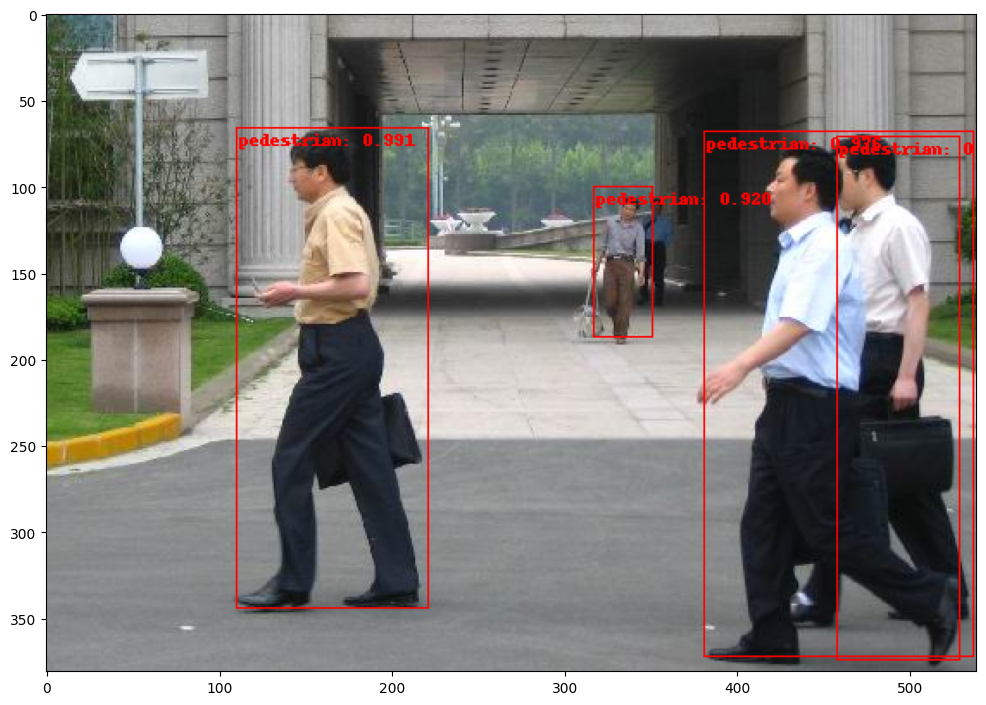

In [52]:
import matplotlib.pyplot as plt
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks


image = read_image("PennFudanPed/PNGImages/FudanPed00007.png")
eval_transform = get_transform(train=False)

with torch.no_grad():
    x = eval_transform(image)
    # convert RGBA -> RGB and move to device
    x = x[:3, ...].to(torch.device('cpu'))
    predictions = quant_rcnn_jit([x, ])
    pred = predictions[1][0]  # JIT model returns tuple ({losses}, [pred_dicts])

threshold = 0.50
image = (255.0 * (image - image.min()) / (image.max() - image.min())).to(torch.uint8)
image = image[:3, ...]
pred_labels = [f"pedestrian: {score:.3f}" for label, score in zip(pred["labels"], pred["scores"]) if score > threshold]
pred_boxes = pred["boxes"].long()[pred["scores"] > threshold]

output_image = draw_bounding_boxes(image, pred_boxes, pred_labels, colors="red")

plt.figure(figsize=(12, 12))
plt.imshow(output_image.permute(1, 2, 0))

... did not have to modify network or insert stubs, fuse model, etc